# Task: Riconoscimento automatico di una review positiva o negativa;

In [702]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

## Get reviews dataset

In [703]:
df_review = pd.read_csv('./dataset/review_dropped.csv')

In [704]:
# review_id // string, 22 character unique review id
# user_id // string, 22 character unique user id, maps to the user in user.json
# business_id // string, 22 character business id, maps to business in business.json
# stars // integer, star rating
# date // string, date formatted YYYY-MM-DD
# text // string, the review itself
# useful // integer, number of useful votes received by review
# funny // integer, number of funny votes received by review
# cool // integer, number of cool votes received by review

In [705]:
# Drop some rows in order to increment performances

# df_review = df_review.iloc[460000:, :]
df_review = df_review.iloc[499000:, :]
df_review = df_review.reset_index()

df_review.head(5)

,level_0,Unnamed: 0,index,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,499000,499000,6989282,NIukhO8BR2wACBztNSRDbQ,Ta9o6-WIRDn5KDvZy8XPNA,jMStvE-tQzSpRCAO0nAE6g,1.0,0.0,0.0,0.0,"Do not eat there! Horrible management, staff a...",2019-05-16 03:34:49
1,499001,499001,6989283,H_-EZhZAZqginAR8EkKxIw,k0qcNly5aTjjr__iNdPKBw,beSgKHecMsEyz6iy7gm-9w,5.0,0.0,0.0,0.0,What a great find! Celebrated out anniversary ...,2021-05-17 01:19:06
2,499002,499002,6989284,aeNMLPf1XGedxQLyTwS8Bg,_0EhXpz__Bs5qNckMW8IEw,Meww6RIE4cFL_kG0aRlbAA,5.0,2.0,0.0,1.0,Great happy hour & great food. I had a great t...,2021-05-09 11:23:03
3,499003,499003,6989285,oDrDjpgNDUXAmrYWU6Q1bQ,tfxcBBdKo28s6OAYNJDM6A,mY4i1N0Hm2fjIgU0Eyn11Q,1.0,2.0,0.0,0.0,"I've been dining here for years, but a recent ...",2021-05-17 22:45:45
4,499004,499004,6989286,jbSsvlNW1VGc-o8b3WBjDw,q6CU8yNwSs2ErfhX3DqaNQ,GxlUXBXe-yw6B5Fqf8kgig,3.0,2.0,1.0,1.0,Food was pretty good. Had the southern fried c...,2016-09-19 23:52:02


### Add boolean positive_review to dataset in order to recognize positive review (>= 4 stars)


In [706]:
df_review['review_rating'] = np.where(df_review['stars'] >= 4, 1, 0)

df_review.head(5)


,level_0,Unnamed: 0,index,review_id,user_id,business_id,stars,useful,funny,cool,text,date,review_rating
0,499000,499000,6989282,NIukhO8BR2wACBztNSRDbQ,Ta9o6-WIRDn5KDvZy8XPNA,jMStvE-tQzSpRCAO0nAE6g,1.0,0.0,0.0,0.0,"Do not eat there! Horrible management, staff a...",2019-05-16 03:34:49,0
1,499001,499001,6989283,H_-EZhZAZqginAR8EkKxIw,k0qcNly5aTjjr__iNdPKBw,beSgKHecMsEyz6iy7gm-9w,5.0,0.0,0.0,0.0,What a great find! Celebrated out anniversary ...,2021-05-17 01:19:06,1
2,499002,499002,6989284,aeNMLPf1XGedxQLyTwS8Bg,_0EhXpz__Bs5qNckMW8IEw,Meww6RIE4cFL_kG0aRlbAA,5.0,2.0,0.0,1.0,Great happy hour & great food. I had a great t...,2021-05-09 11:23:03,1
3,499003,499003,6989285,oDrDjpgNDUXAmrYWU6Q1bQ,tfxcBBdKo28s6OAYNJDM6A,mY4i1N0Hm2fjIgU0Eyn11Q,1.0,2.0,0.0,0.0,"I've been dining here for years, but a recent ...",2021-05-17 22:45:45,0
4,499004,499004,6989286,jbSsvlNW1VGc-o8b3WBjDw,q6CU8yNwSs2ErfhX3DqaNQ,GxlUXBXe-yw6B5Fqf8kgig,3.0,2.0,1.0,1.0,Food was pretty good. Had the southern fried c...,2016-09-19 23:52:02,0


### Plot reviews

Positive reviews: 653
Negative reviews: 347


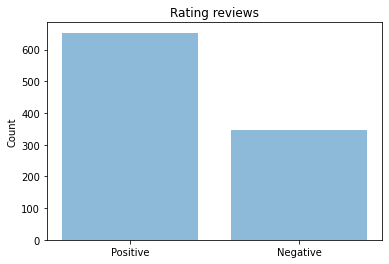

In [707]:
positive_count = (df_review['review_rating'] == 1).sum()
negative_count = (df_review['review_rating'] == 0).sum()

print("Positive reviews:", positive_count)

print("Negative reviews:", negative_count)

objects = ('Positive', 'Negative')
performance = [positive_count, negative_count]
y_pos = np.arange(len(objects))

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Rating reviews')

plt.show()



# Text preprocessing


#### Create working df

In [708]:
df_review_text_rating = df_review[['text', 'review_rating']].copy()

In [709]:
import nltk

## Normalization

### Expand English contractions

In [710]:
import contractions

In [711]:
def expand(row):
    expanded_words = []
    for word in row['text'].split():
        expanded_words.append(contractions.fix(word))
    return ' '.join(expanded_words)


df_review_text_rating['expanded_text'] = df_review_text_rating.apply(expand, axis=1)

In [712]:
df_review_text_rating.head(5)

,text,review_rating,expanded_text
0,"Do not eat there! Horrible management, staff a...",0,"Do not eat there! Horrible management, staff a..."
1,What a great find! Celebrated out anniversary ...,1,What a great find! Celebrated out anniversary ...
2,Great happy hour & great food. I had a great t...,1,Great happy hour & great food. I had a great t...
3,"I've been dining here for years, but a recent ...",0,"I have been dining here for years, but a recen..."
4,Food was pretty good. Had the southern fried c...,0,Food was pretty good. Had the southern fried c...


## Tokenize

In [713]:
from nltk.tokenize import word_tokenize

In [714]:
def tokenize(row):
    return word_tokenize(row['expanded_text'])


df_review_text_rating['tokenized_text'] = df_review_text_rating.apply(tokenize, axis=1)

In [715]:
df_review_text_rating.head(5)

,text,review_rating,expanded_text,tokenized_text
0,"Do not eat there! Horrible management, staff a...",0,"Do not eat there! Horrible management, staff a...","[Do, not, eat, there, !, Horrible, management,..."
1,What a great find! Celebrated out anniversary ...,1,What a great find! Celebrated out anniversary ...,"[What, a, great, find, !, Celebrated, out, ann..."
2,Great happy hour & great food. I had a great t...,1,Great happy hour & great food. I had a great t...,"[Great, happy, hour, &, great, food, ., I, had..."
3,"I've been dining here for years, but a recent ...",0,"I have been dining here for years, but a recen...","[I, have, been, dining, here, for, years, ,, b..."
4,Food was pretty good. Had the southern fried c...,0,Food was pretty good. Had the southern fried c...,"[Food, was, pretty, good, ., Had, the, souther..."


## Remove puncts

In [716]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/at181903/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [717]:
def remove_punct(row):
    return [word for word in row['tokenized_text'] if word.isalpha()]


df_review_text_rating['no_punct_text'] = df_review_text_rating.apply(remove_punct, axis=1)

In [718]:
df_review_text_rating.head(5)

,text,review_rating,expanded_text,tokenized_text,no_punct_text
0,"Do not eat there! Horrible management, staff a...",0,"Do not eat there! Horrible management, staff a...","[Do, not, eat, there, !, Horrible, management,...","[Do, not, eat, there, Horrible, management, st..."
1,What a great find! Celebrated out anniversary ...,1,What a great find! Celebrated out anniversary ...,"[What, a, great, find, !, Celebrated, out, ann...","[What, a, great, find, Celebrated, out, annive..."
2,Great happy hour & great food. I had a great t...,1,Great happy hour & great food. I had a great t...,"[Great, happy, hour, &, great, food, ., I, had...","[Great, happy, hour, great, food, I, had, a, g..."
3,"I've been dining here for years, but a recent ...",0,"I have been dining here for years, but a recen...","[I, have, been, dining, here, for, years, ,, b...","[I, have, been, dining, here, for, years, but,..."
4,Food was pretty good. Had the southern fried c...,0,Food was pretty good. Had the southern fried c...,"[Food, was, pretty, good, ., Had, the, souther...","[Food, was, pretty, good, Had, the, southern, ..."


## Stemming

In [719]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()

In [720]:
def stemming(row):
    return [ps.stem(word) for word in row['no_punct_text']]


df_review_text_rating['stemmed_text'] = df_review_text_rating.apply(stemming, axis=1)

In [721]:
df_review_text_rating.head(5)

,text,review_rating,expanded_text,tokenized_text,no_punct_text,stemmed_text
0,"Do not eat there! Horrible management, staff a...",0,"Do not eat there! Horrible management, staff a...","[Do, not, eat, there, !, Horrible, management,...","[Do, not, eat, there, Horrible, management, st...","[do, not, eat, there, horribl, manag, staff, a..."
1,What a great find! Celebrated out anniversary ...,1,What a great find! Celebrated out anniversary ...,"[What, a, great, find, !, Celebrated, out, ann...","[What, a, great, find, Celebrated, out, annive...","[what, a, great, find, celebr, out, anniversar..."
2,Great happy hour & great food. I had a great t...,1,Great happy hour & great food. I had a great t...,"[Great, happy, hour, &, great, food, ., I, had...","[Great, happy, hour, great, food, I, had, a, g...","[great, happi, hour, great, food, i, had, a, g..."
3,"I've been dining here for years, but a recent ...",0,"I have been dining here for years, but a recen...","[I, have, been, dining, here, for, years, ,, b...","[I, have, been, dining, here, for, years, but,...","[i, have, been, dine, here, for, year, but, a,..."
4,Food was pretty good. Had the southern fried c...,0,Food was pretty good. Had the southern fried c...,"[Food, was, pretty, good, ., Had, the, souther...","[Food, was, pretty, good, Had, the, southern, ...","[food, wa, pretti, good, had, the, southern, f..."


## Lemmatization

In [722]:
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/at181903/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/at181903/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [723]:
def lemmatization(row):
    return [lemmatizer.lemmatize(word) for word in row['stemmed_text']]


df_review_text_rating['lemmatized_text'] = df_review_text_rating.apply(lemmatization, axis=1)

In [724]:
df_review_text_rating.head(5)

,text,review_rating,expanded_text,tokenized_text,no_punct_text,stemmed_text,lemmatized_text
0,"Do not eat there! Horrible management, staff a...",0,"Do not eat there! Horrible management, staff a...","[Do, not, eat, there, !, Horrible, management,...","[Do, not, eat, there, Horrible, management, st...","[do, not, eat, there, horribl, manag, staff, a...","[do, not, eat, there, horribl, manag, staff, a..."
1,What a great find! Celebrated out anniversary ...,1,What a great find! Celebrated out anniversary ...,"[What, a, great, find, !, Celebrated, out, ann...","[What, a, great, find, Celebrated, out, annive...","[what, a, great, find, celebr, out, anniversar...","[what, a, great, find, celebr, out, anniversar..."
2,Great happy hour & great food. I had a great t...,1,Great happy hour & great food. I had a great t...,"[Great, happy, hour, &, great, food, ., I, had...","[Great, happy, hour, great, food, I, had, a, g...","[great, happi, hour, great, food, i, had, a, g...","[great, happi, hour, great, food, i, had, a, g..."
3,"I've been dining here for years, but a recent ...",0,"I have been dining here for years, but a recen...","[I, have, been, dining, here, for, years, ,, b...","[I, have, been, dining, here, for, years, but,...","[i, have, been, dine, here, for, year, but, a,...","[i, have, been, dine, here, for, year, but, a,..."
4,Food was pretty good. Had the southern fried c...,0,Food was pretty good. Had the southern fried c...,"[Food, was, pretty, good, ., Had, the, souther...","[Food, was, pretty, good, Had, the, southern, ...","[food, wa, pretti, good, had, the, southern, f...","[food, wa, pretti, good, had, the, southern, f..."


## Remove stopwords

In [725]:
# from nltk.corpus import stopwords
# nltk.download('stopwords')

In [726]:
# df_review_text_no_stopwords = df_review_text_lemmatized
#
# def remove_stopwords(row):
#   return [word for word in row['lemmatized_text'] if not word in stopwords.words()]
#
# df_review_text_no_stopwords['no_stopwords'] = df_review_text_no_stopwords.apply(remove_stopwords, axis=1)

In [727]:
# df_review_text_no_stopwords.head(5)

## Rejoin words after processing

In [728]:
def join_words(row):
    return " ".join(row['lemmatized_text'])


df_review_text_rating['processed_text'] = df_review_text_rating.apply(join_words, axis=1)

df_review_text_rating

,text,review_rating,expanded_text,tokenized_text,no_punct_text,stemmed_text,lemmatized_text,processed_text
0,"Do not eat there! Horrible management, staff a...",0,"Do not eat there! Horrible management, staff a...","[Do, not, eat, there, !, Horrible, management,...","[Do, not, eat, there, Horrible, management, st...","[do, not, eat, there, horribl, manag, staff, a...","[do, not, eat, there, horribl, manag, staff, a...",do not eat there horribl manag staff and food ...
1,What a great find! Celebrated out anniversary ...,1,What a great find! Celebrated out anniversary ...,"[What, a, great, find, !, Celebrated, out, ann...","[What, a, great, find, Celebrated, out, annive...","[what, a, great, find, celebr, out, anniversar...","[what, a, great, find, celebr, out, anniversar...",what a great find celebr out anniversari and t...
2,Great happy hour & great food. I had a great t...,1,Great happy hour & great food. I had a great t...,"[Great, happy, hour, &, great, food, ., I, had...","[Great, happy, hour, great, food, I, had, a, g...","[great, happi, hour, great, food, i, had, a, g...","[great, happi, hour, great, food, i, had, a, g...",great happi hour great food i had a great time...
3,"I've been dining here for years, but a recent ...",0,"I have been dining here for years, but a recen...","[I, have, been, dining, here, for, years, ,, b...","[I, have, been, dining, here, for, years, but,...","[i, have, been, dine, here, for, year, but, a,...","[i, have, been, dine, here, for, year, but, a,...",i have been dine here for year but a recent ho...
4,Food was pretty good. Had the southern fried c...,0,Food was pretty good. Had the southern fried c...,"[Food, was, pretty, good, ., Had, the, souther...","[Food, was, pretty, good, Had, the, southern, ...","[food, wa, pretti, good, had, the, southern, f...","[food, wa, pretti, good, had, the, southern, f...",food wa pretti good had the southern fri chick...
...,...,...,...,...,...,...,...,...
995,Latest addition to services from ICCU is Apple...,1,Latest addition to services from ICCU is Apple...,"[Latest, addition, to, services, from, ICCU, i...","[Latest, addition, to, services, from, ICCU, i...","[latest, addit, to, servic, from, iccu, is, ap...","[latest, addit, to, servic, from, iccu, is, ap...",latest addit to servic from iccu is appl pay f...
996,"This spot offers a great, affordable east week...",1,"This spot offers a great, affordable east week...","[This, spot, offers, a, great, ,, affordable, ...","[This, spot, offers, a, great, affordable, eas...","[thi, spot, offer, a, great, afford, east, wee...","[thi, spot, offer, a, great, afford, east, wee...",thi spot offer a great afford east weekend pad...
997,This Home Depot won me over when I needed to g...,1,This Home Depot won me over when I needed to g...,"[This, Home, Depot, won, me, over, when, I, ne...","[This, Home, Depot, won, me, over, when, I, ne...","[thi, home, depot, won, me, over, when, i, nee...","[thi, home, depot, won, me, over, when, i, nee...",thi home depot won me over when i need to get ...
998,For when I'm feeling like ignoring my calorie-...,1,For when I am feeling like ignoring my calorie...,"[For, when, I, am, feeling, like, ignoring, my...","[For, when, I, am, feeling, like, ignoring, my...","[for, when, i, am, feel, like, ignor, my, and,...","[for, when, i, am, feel, like, ignor, my, and,...",for when i am feel like ignor my and indulg in...


## Split dataframe in training_set and test_set

In [729]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [730]:
X = df_review_text_rating["processed_text"]
y = df_review_text_rating["review_rating"]

# Training set = 80%
# Test set = 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [737]:
# Initialize
vectorizer = TfidfVectorizer()
X_train_vectorizer = vectorizer.fit_transform(X_train)
X_test_vectorizer = vectorizer.transform(X_test)

X_train_df = pd.DataFrame(columns=vectorizer.get_feature_names_out(), data=X_train_vectorizer.toarray())
X_test_df = pd.DataFrame(columns=vectorizer.get_feature_names_out(), data=X_test_vectorizer.toarray())

In [738]:
X_train_df.head(5)

,abe,abid,abil,abita,abl,about,abov,abrupt,abruptli,absolut,...,zero,zest,zip,ziplock,zlt,zoal,zucchini,zumba,zushipok,ànd
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.072876,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [739]:
X_test_df.head(5)

,abe,abid,abil,abita,abl,about,abov,abrupt,abruptli,absolut,...,zero,zest,zip,ziplock,zlt,zoal,zucchini,zumba,zushipok,ànd
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.064824,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Algorithms

In [ ]:
# Features as Array
# features = np.array(vectorizer.get_feature_names_out())

In [741]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## AdaBoostClassifier

In [756]:
parameters = {'n_estimators':[10,50,100,250,500],
              'learning_rate':[0.01,0.1],
              'algorithm' : ['SAMME', 'SAMME.R']}

gs_ada = GridSearchCV(AdaBoostClassifier(), parameters,verbose=3,scoring='f1',n_jobs=-1)

gs_ada.fit(X_train_vectorizer,y_train)

print(gs_ada.best_params_)

# Find best model score
gs_ada.score(X_train_vectorizer, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 250}


0.9663551401869159

In [758]:
ada = AdaBoostClassifier(n_estimators=250, learning_rate=0.1, algorithm='SAMME.R')

# Training model
ada.fit(X_train_vectorizer, y_train)

# Predicting the test set results
y_pred_ada = ada.predict(X_test_vectorizer)

# Training score
print(f"Score on training set: {ada.score(X_train_vectorizer,y_train)}")
print(f"Score on test set: {ada.score(X_test_vectorizer,y_test)}")

Score on training set: 0.955
Score on test set: 0.85


## GaussianNB

## DecisionTreeClassifier

## LogisticRegression

## KNeighborsClassifier

## Support Vector Machine

## RandomForestClassifier